In [5]:
from pyspark import SparkConf, SparkContext

sc._conf.setAll([('spark.executor.memory', '8g'), 
                 ('spark.executor.cores', '8g'), 
                 ('spark.cores.max', '8g'),
                 ('spark.driver.maxResultSize', '10g'), 
                 ('spark.driver.memory','45g')])

conf = SparkConf().setMaster("local[*]").setAppName("SNA")
sc = SparkContext(conf=conf)

# 1. data: zachary karate club dataset
+ 34 members in the club
+ 78 edges in total 
+ undirected
+ unweighted

@inproceedings{nr,
     title={The Network Data Repository with Interactive Graph Analytics and Visualization},
     author={Ryan A. Rossi and Nesreen K. Ahmed},
     booktitle={AAAI},
     url={http://networkrepository.com},
     year={2015}
}

## (1) Summary
+ neighbors_dict: 每一個member周圍所有有聯結的member
  ex. neighbors_dict["1"] -> ['2','3','4']
+ members: 所有的member

In [1]:
network1 = sc.textFile("C:\\Users\\admin\\ucidata-zachary.edges.txt",2).map(lambda x: x.split(","))

In [2]:
network2 = network1.map(lambda x:(x[1],x[0]))

In [3]:
network = network1.union(network2)

In [4]:
neighbors = network.groupByKey().map(lambda x: (x[0], list(x[1])))

In [5]:
neighbors.take(1)

[('4', ['8', '13', '14', '1', '2', '3'])]

In [5]:
neighbors_dict = dict(neighbors.collect())

In [7]:
neighbors_dict["1"]

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '11',
 '12',
 '13',
 '14',
 '18',
 '20',
 '22',
 '32']

In [6]:
member = neighbors.map(lambda x:x[0])

In [7]:
member.cache().collect()

['4',
 '24',
 '26',
 '16',
 '10',
 '20',
 '12',
 '3',
 '6',
 '7',
 '25',
 '15',
 '23',
 '30',
 '31',
 '32',
 '18',
 '1',
 '9',
 '29',
 '19',
 '21',
 '14',
 '33',
 '8',
 '17',
 '22',
 '34',
 '2',
 '5',
 '27',
 '28',
 '11',
 '13']

In [8]:
# all members
members = member.collect()

# 2. Implement Girvan Newman Algorithm 

## (1) Implement Depth-First-Search

In [9]:
def find_path(x):
    
    # x裡面的members有沒有"全"在目前為止path上的所有members中
    def all_in_all_element(x):
        boolean = True
        for c in x:
            if c in all_element:
                continue
            else:
                boolean = False
                break
        return boolean
    
    #第一層:root本身
    all_element = []
    all_element.append(x)
    path = []
    path.append([x])
    
    
    # 第二層
    level_2 = []
    for c in neighbors_dict[x]:
        if c not in all_element:
            level_2.append(c)
            all_element.append(c)
    path.append(level_2)
    
    #持續好幾層，直到找不到為止
    while path[-1] != []:
        level = []
        for c in level_2:
            if  all_in_all_element(neighbors_dict[c]) == False:
                for k in neighbors_dict[c]:
                    if k not in all_element:
                        level.append(k)
                        all_element.append(k)
        path.append(level)
        level_2 = level

    return path

## (2) 找出每個edge的betweenness score

In [10]:
def find_betweenness(x): # ex. find_betweenness("56")
    
    # 在find_path("56")中，逐層計算steps
    steps = {}
    for c in find_path(x)[0]:
        steps.update({c:1})
    for c in find_path(x)[1]:
        steps.update({c:1})
    for i in range(2,len(find_path(x))):
        for c in find_path(x)[i]:
            count = 0
            for k in find_path(x)[i-1]:
                if k in neighbors_dict[c]:
                    count += steps[k]
            steps.update({c:count})
            
    # 為了方便後續計算，再用find_path找出path中每一個member的直系上一層(parent)
    # family -> 所有member與它的parent的dictionary
    family = {}
    i = 0
    while i+1 < len(find_path(x)):
        for c in find_path(x)[i+1]:
            parent = []
            for k in find_path(x)[i]:
                if k in neighbors_dict[c]:
                    parent.append(k)
            family.update({c:parent})
        i += 1
    
    
    # 計算在path上的所有edge的betweenness score
    edge = {}
    betweenness_score = {}
    for c in find_path(x):
        for k in c:
            edge.update({k:1})
    i = len(find_path(x))-1
    while i > 0:
        for c in find_path(x)[i]:
            for k in family[c]:
                betweenness_score.update({(k,c):edge[c]*(steps[k]/steps[c])})
                edge.update({k:edge[k]+edge[c]*(steps[k]/steps[c])})
        i -= 1
    
    # 為了方便後續計算，將edge的表示方式調整成('34/15')且前面的數字一定比後面的大
    betweenness_score_list = []
    for c in betweenness_score:
        bigger = max(eval(c[0]),eval(c[1]))
        smaller = min(eval(c[0]),eval(c[1]))
        edge_id = str(bigger)+"/"+str(smaller)
        betweenness_score_list.append((edge_id,betweenness_score[c]))
    
    
    
    return betweenness_score_list

運用RDD將所有重複的edge的score加總並從大排到小排序

In [11]:
betweenness_scores = member.flatMap(find_betweenness) #找出每個edge的betweenness

In [14]:
betweenness_scores.take(1)  #[('34/15', 0.5)]

[('34/15', 0.5)]

In [12]:
betweenness_reduce = betweenness_scores.reduceByKey(lambda x,y: x+y) #重複的edge的score加起來

In [16]:
betweenness_reduce.take(1)  #[('34/15', 38.977777777777774)]

[('34/15', 38.977777777777774)]

In [13]:
reduce_sort = betweenness_reduce.sortBy(lambda x: x[1],False) #排序

In [18]:
reduce_sort.take(1)  #('32/1', 142.78571428571428)]

[('32/1', 142.78571428571428)]

In [19]:
reduce_sort.cache().collect()

[('32/1', 142.78571428571428),
 ('7/1', 87.66666666666666),
 ('6/1', 87.66666666666666),
 ('3/1', 87.27777777777779),
 ('9/1', 83.2968253968254),
 ('33/3', 77.40317460317459),
 ('34/14', 76.0984126984127),
 ('34/20', 66.62698412698413),
 ('12/1', 66.0),
 ('34/27', 60.91428571428571),
 ('34/32', 59.907936507936505),
 ('5/1', 58.66666666666666),
 ('11/1', 58.66666666666666),
 ('13/1', 52.2),
 ('20/1', 51.54126984126984),
 ('14/1', 47.54126984126984),
 ('32/26', 47.1888888888889),
 ('33/32', 46.48888888888889),
 ('28/3', 46.21746031746032),
 ('34/9', 45.369841269841274),
 ('18/1', 45.01904761904762),
 ('22/1', 45.01904761904762),
 ('32/25', 45.0),
 ('34/15', 38.977777777777774),
 ('34/16', 38.977777777777774),
 ('34/23', 38.977777777777774),
 ('34/19', 38.977777777777774),
 ('34/21', 38.977777777777774),
 ('34/24', 36.65555555555555),
 ('31/2', 36.219047619047615),
 ('10/3', 34.56190476190476),
 ('34/28', 34.195238095238096),
 ('33/9', 34.15555555555555),
 ('34/30', 33.44444444444444),
 (

## (3) 從betweenness score最高的edge開始斷開

In [14]:
cut_order = reduce_sort.map(lambda x: x[0].split("/")) #總分不重要，只留下edge斷開的順序

In [15]:
degree = {c:len(neighbors_dict[c]) for c in neighbors_dict} #計算modularity需要知道每個member的degree

In [16]:
cut_order_list = cut_order.collect()

In [23]:
cut_order_list #[("32","1"),...]

[['32', '1'],
 ['7', '1'],
 ['6', '1'],
 ['3', '1'],
 ['9', '1'],
 ['33', '3'],
 ['34', '14'],
 ['34', '20'],
 ['12', '1'],
 ['34', '27'],
 ['34', '32'],
 ['5', '1'],
 ['11', '1'],
 ['13', '1'],
 ['20', '1'],
 ['14', '1'],
 ['32', '26'],
 ['33', '32'],
 ['28', '3'],
 ['34', '9'],
 ['18', '1'],
 ['22', '1'],
 ['32', '25'],
 ['34', '15'],
 ['34', '16'],
 ['34', '23'],
 ['34', '19'],
 ['34', '21'],
 ['34', '24'],
 ['31', '2'],
 ['10', '3'],
 ['34', '28'],
 ['33', '9'],
 ['34', '30'],
 ['34', '10'],
 ['17', '6'],
 ['17', '7'],
 ['34', '31'],
 ['2', '1'],
 ['8', '3'],
 ['34', '29'],
 ['33', '21'],
 ['33', '15'],
 ['33', '16'],
 ['33', '19'],
 ['33', '23'],
 ['33', '30'],
 ['3', '2'],
 ['8', '1'],
 ['29', '3'],
 ['4', '3'],
 ['33', '24'],
 ['4', '1'],
 ['26', '24'],
 ['22', '2'],
 ['18', '2'],
 ['28', '25'],
 ['33', '31'],
 ['14', '4'],
 ['32', '29'],
 ['20', '2'],
 ['14', '2'],
 ['13', '4'],
 ['28', '24'],
 ['31', '9'],
 ['9', '3'],
 ['34', '33'],
 ['4', '2'],
 ['14', '3'],
 ['8', '2'],
 ['

In [17]:
import itertools

## root&leaf
+ root: 能用最少的路徑到達所有的點 -> 核心
+ leaf: 其他不是核心的member

In [18]:
def find_root(x):
    path_length = []
    for c in x:
        path_length.append(len(find_path(c)))
    return min(path_length)        

In [19]:
find_root(members) #最少路徑是5

5

In [20]:
root = [i for i in itertools.filterfalse(lambda x: len(find_path(x)) != 5, members)] #最核心的members -> 路徑長度5

In [21]:
leaf = [i for i in itertools.filterfalse(lambda x:x in root, members)] #核心member以外的人

In [22]:
neighbors_dict = dict(neighbors.collect())

In [30]:
cut_order_list

[['32', '1'],
 ['7', '1'],
 ['6', '1'],
 ['3', '1'],
 ['9', '1'],
 ['33', '3'],
 ['34', '14'],
 ['34', '20'],
 ['12', '1'],
 ['34', '27'],
 ['34', '32'],
 ['5', '1'],
 ['11', '1'],
 ['13', '1'],
 ['20', '1'],
 ['14', '1'],
 ['32', '26'],
 ['33', '32'],
 ['28', '3'],
 ['34', '9'],
 ['18', '1'],
 ['22', '1'],
 ['32', '25'],
 ['34', '15'],
 ['34', '16'],
 ['34', '23'],
 ['34', '19'],
 ['34', '21'],
 ['34', '24'],
 ['31', '2'],
 ['10', '3'],
 ['34', '28'],
 ['33', '9'],
 ['34', '30'],
 ['34', '10'],
 ['17', '6'],
 ['17', '7'],
 ['34', '31'],
 ['2', '1'],
 ['8', '3'],
 ['34', '29'],
 ['33', '21'],
 ['33', '15'],
 ['33', '16'],
 ['33', '19'],
 ['33', '23'],
 ['33', '30'],
 ['3', '2'],
 ['8', '1'],
 ['29', '3'],
 ['4', '3'],
 ['33', '24'],
 ['4', '1'],
 ['26', '24'],
 ['22', '2'],
 ['18', '2'],
 ['28', '25'],
 ['33', '31'],
 ['14', '4'],
 ['32', '29'],
 ['20', '2'],
 ['14', '2'],
 ['13', '4'],
 ['28', '24'],
 ['31', '9'],
 ['9', '3'],
 ['34', '33'],
 ['4', '2'],
 ['14', '3'],
 ['8', '2'],
 ['

In [23]:
winner_list = [[],0]

In [24]:
neighbors_dict_1 = dict(neighbors.collect())

In [61]:
# group definitions / combinations
winner_list = [[],0]
winner_for_loop = []
neighbors_dict = dict(neighbors.collect())
Increased = False

for f in range(10):
    neighbors_dict = dict(neighbors.collect())
    for c in cut_order_list:
        all_element = []
        a1 = c[0]
        a2 = c[1]

        neighbors_dict[c[0]].remove(c[1])
        neighbors_dict[c[1]].remove(c[0])

    ##找出graph中所有的components--------------------------------------------------------------------   
        component = []

        #找第一個component
        for c in find_path("23"): #"23"只是隨便一個數字，不管是任何數字應該都能找到同樣的結果
            for k in c:
                component.append(k)
                all_element.append(k)
        for c in component:
            for k in neighbors_dict[c]:
                if k not in component:
                    component.append(k)
                    all_element.append(k)



        components = [component]


        #找其他component
        while len(set(members)) != len(set(all_element)):
            candidate = [c for c in members if c not in all_element]
            try:
                component = []
                for c in find_path(candidate[0]):
                    for k in c:
                        component.append(k)
                        all_element.append(k)
                components.append(component)
            except:
                pass

    ##已斷開的edge連回去的條件--------------------------------------------------------------------------------
        #不希望出現只有一個1個或2個的group被從大群裡面丟出來 <-> 定義一個group至少3人
        Add_back = False
        if any(len(c)<=2 for c in components) == True:  #如果出現這樣的情況則把edge連回去
            neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
            neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))
            Add_back = True

        if  Add_back == True:
            pass
        else:

    ##計算modularity------------------------------------------------------------------------------------------ 
            M = 0  #graph中edge的總量
            Q = 0  #modularity

            #先算M(graph中edge的總量)
            for i in members:
                M += degree[i]
            #再算Q
            for c in components:
                #同一個group裡面兩個兩個加值到Q
                for k in list(itertools.combinations(c , 2)):
                    if k[1] in neighbors_dict_1[k[0]]:
                        Q += 1-degree[k[1]]*degree[k[0]]/(2*M)
                    else:
                        Q += -degree[k[1]]*degree[k[0]]/(2*M)


    ##將現有的component重組看看，可能可以得到更好的modularity---------------------------------------------

            if len(components) == 1:   #只有一個group的時候就沒有組合的可能
                pass
            else:
                Q_list_c = []
                combination_list = []
                for c in list(itertools.combinations(components , 2)):
                    combinations = []
                    new_component = list(itertools.chain(c[0],c[1]))
                    another = [c for c in itertools.filterfalse(lambda x: x in new_component, members)]
                    combinations.append(new_component)
                    combinations.append(another)
                    combination_list.append(combinations)

                    Q_c = 0

                    for c in combinations:
                        for k in list(itertools.combinations(c,2)):
                            if k[1] in neighbors_dict_1[k[0]]:

                                Q_c += 1-degree[k[1]]*degree[k[0]]/(2*M)
                            else:
                                Q_c += -degree[k[1]]*degree[k[0]]/(2*M)


                    Q_list_c.append(Q_c)
                #在所有組合中擁有最大Q值的組合被留下來
                winner_combination = [combination_list[Q_list_c.index(max(Q_list_c))],max(Q_list_c)/(2*M)]
    #                 print(winner_combination)
    ##來比較一下吧------------------------------------------------------------------------------------------
            if len(components) != 1:  #只有一個group的時候，沒有組合 ->會出現ERROR
                #把這次切斷所形成的graph和最大Q組合的graph以及在上一個loop中擁有最大Q的衛冕者做比較
                challengers = [Q/(2*M), winner_list[1], winner_combination[1]]
                support = ["components","winner_list[0]", "winner_combination[0]"]


            if len(components) < int(f):  #由於必須切割到一定程度，組合的Q才會開始有組合效益
                pass
            else:
                if Q/(2*M) > winner_list[1]:
                    winner_list[0] = components
                    winner_list[1] = Q/(2*M)
                    

                else:
                    neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
                    neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))
                    Add_back = True

                if len(components) != 1:
                    ##最後留下來的就是那次loop勝出的衛冕者
                    winner_list[0] = eval(support[challengers.index(max(challengers))])
                    winner_list[1] = max(challengers)
##for loop 什麼時候停
    winner_for_loop.append(winner_list[1])
    try:
        if Increased == True:
            if winner_for_loop[-1] == winner_for_loop[-2]:
                break
        if winner_for_loop[-1] > winner_for_loop[-2]:
            Increased = True
        
    except:
        pass
    
                                    

In [62]:
list(winner_list)

[[['23',
   '33',
   '21',
   '15',
   '16',
   '19',
   '31',
   '34',
   '9',
   '10',
   '3',
   '29',
   '32',
   '24',
   '30',
   '28',
   '27',
   '25',
   '26'],
  ['4',
   '20',
   '12',
   '6',
   '7',
   '18',
   '1',
   '14',
   '8',
   '17',
   '22',
   '2',
   '5',
   '11',
   '13']],
 0.16019477317554234]

In [54]:
#demo1 - no group definition / combinations
winner_list_1 = [[],0]
winner_for_loop_1 = []
neighbors_dict = dict(neighbors.collect())
Increased = False

for f in range(10):
    neighbors_dict = dict(neighbors.collect())
    for c in cut_order_list:
        all_element = []
        a1 = c[0]
        a2 = c[1]

    
        neighbors_dict[c[0]].remove(c[1])
        neighbors_dict[c[1]].remove(c[0])

    ##找出graph中所有的components--------------------------------------------------------------------   
        component = []

        #找第一個component
        for c in find_path("23"): #"23"只是隨便一個數字，不管是任何數字應該都能找到同樣的結果
            for k in c:
                component.append(k)
                all_element.append(k)
        for c in component:
            for k in neighbors_dict[c]:
                if k not in component:
                    component.append(k)
                    all_element.append(k)



        components = [component]


        #找其他component
        while len(set(members)) != len(set(all_element)):
            candidate = [c for c in members if c not in all_element]
            try:
                component = []
                for c in find_path(candidate[0]):
                    for k in c:
                        component.append(k)
                        all_element.append(k)
                components.append(component)
            except:
                pass

    ##已斷開的edge連回去的條件--------------------------------------------------------------------------- Problem 2
        #不希望出現只有一個1個或2個的group被從大群裡面丟出來 <-> 定義一個group至少3人
#         Add_back = False
#         if any(len(c)<=2 for c in components) == True:  #如果出現這樣的情況則把edge連回去
#             neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
#             neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))
#             Add_back = True

#         if  Add_back == True:
#             pass
        if 1+1 != 2:
            pass
        else:

    ##計算modularity------------------------------------------------------------------------------------------ 
            M = 0  #graph中edge的總量
            Q = 0  #modularity

            #先算M(graph中edge的總量)
            for i in members:
                M += degree[i]
            #再算Q
            for c in components:
                #同一個group裡面兩個兩個加值到Q
                for k in list(itertools.combinations(c , 2)):
                    if k[1] in neighbors_dict_1[k[0]]:
                        Q += 1-degree[k[1]]*degree[k[0]]/(2*M)
                    else:
                        Q += -degree[k[1]]*degree[k[0]]/(2*M)


    ##將現有的component重組看看，可能可以得到更好的modularity---------------------------------------------   for the best Q

            if len(components) == 1:   #只有一個group的時候就沒有組合的可能
                pass
            else:
                Q_list_c = []
                combination_list = []
                for c in list(itertools.combinations(components , 2)):
                    combinations = []
                    new_component = list(itertools.chain(c[0],c[1]))
                    another = [c for c in itertools.filterfalse(lambda x: x in new_component, members)]
                    combinations.append(new_component)
                    combinations.append(another)
                    combination_list.append(combinations)

                    Q_c = 0

                    for c in combinations:
                        for k in list(itertools.combinations(c,2)):
                            if k[1] in neighbors_dict_1[k[0]]:

                                Q_c += 1-degree[k[1]]*degree[k[0]]/(2*M)
                            else:
                                Q_c += -degree[k[1]]*degree[k[0]]/(2*M)


                    Q_list_c.append(Q_c)
                #在所有組合中擁有最大Q值的組合被留下來
                winner_combination = [combination_list[Q_list_c.index(max(Q_list_c))],max(Q_list_c)/(2*M)]
    #                 print(winner_combination)
    ##來比較一下吧------------------------------------------------------------------------------------------
            if len(components) != 1:  #只有一個group的時候，沒有組合 ->會出現ERROR
                #把這次切斷所形成的graph和最大Q組合的graph以及在上一個loop中擁有最大Q的衛冕者做比較
                challengers = [Q/(2*M), winner_list[1], winner_combination[1]]
                support = ["components","winner_list[0]", "winner_combination[0]"]


            if len(components) < int(f):  #由於必須切割到一定程度，組合的Q才會開始有組合效益
                pass
            else:
                if Q/(2*M) > winner_list_1[1]:
                    winner_list_1[0] = components
                    winner_list_1[1] = Q/(2*M)

                else:
                    neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
                    neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))

                if len(components) != 1:
                    ##最後留下來的就是那次loop勝出的衛冕者
                    winner_list[0] = eval(support[challengers.index(max(challengers))])
                    winner_list[1] = max(challengers)
##for loop 什麼時候停
    winner_for_loop_1.append(winner_list_1[1])
    try:
        if Increased == True:
            if winner_for_loop_1[-1] == winner_for_loop_1[-2]:
                break
        if winner_for_loop_1[-1] > winner_for_loop_1[-2]:
            Increased = True
        
    except:
        pass
    
                                    

In [55]:
list(winner_list_1)

[[['23',
   '33',
   '21',
   '15',
   '16',
   '19',
   '24',
   '31',
   '34',
   '30',
   '28',
   '9',
   '27',
   '25',
   '3',
   '26',
   '29',
   '32'],
  ['4', '8', '1', '13', '2', '22', '18', '20', '14'],
  ['10'],
  ['12'],
  ['6', '7', '11', '5', '17']],
 0.14828854372123593]

In [56]:
#demo2 - group definations / no combinations
winner_list_1 = [[],0]
winner_for_loop_1 = []
neighbors_dict = dict(neighbors.collect())
Increased = False

for f in range(10):
    neighbors_dict = dict(neighbors.collect())
    for c in cut_order_list:
        all_element = []
        a1 = c[0]
        a2 = c[1]

    
        neighbors_dict[c[0]].remove(c[1])
        neighbors_dict[c[1]].remove(c[0])

    ##找出graph中所有的components--------------------------------------------------------------------   
        component = []

        #找第一個component
        for c in find_path("23"): #"23"只是隨便一個數字，不管是任何數字應該都能找到同樣的結果
            for k in c:
                component.append(k)
                all_element.append(k)
        for c in component:
            for k in neighbors_dict[c]:
                if k not in component:
                    component.append(k)
                    all_element.append(k)



        components = [component]


        #找其他component
        while len(set(members)) != len(set(all_element)):
            candidate = [c for c in members if c not in all_element]
            try:
                component = []
                for c in find_path(candidate[0]):
                    for k in c:
                        component.append(k)
                        all_element.append(k)
                components.append(component)
            except:
                pass

    ##已斷開的edge連回去的條件--------------------------------------------------------------------------- Problem 2
        #不希望出現只有一個1個或2個的group被從大群裡面丟出來 <-> 定義一個group至少3人
        Add_back = False
        if any(len(c)<=2 for c in components) == True:  #如果出現這樣的情況則把edge連回去
            neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
            neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))
            Add_back = True

        if  Add_back == True:
            pass
        else:

    ##計算modularity------------------------------------------------------------------------------------------ 
            M = 0  #graph中edge的總量
            Q = 0  #modularity

            #先算M(graph中edge的總量)
            for i in members:
                M += degree[i]
            #再算Q
            for c in components:
                #同一個group裡面兩個兩個加值到Q
                for k in list(itertools.combinations(c , 2)):
                    if k[1] in neighbors_dict_1[k[0]]:
                        Q += 1-degree[k[1]]*degree[k[0]]/(2*M)
                    else:
                        Q += -degree[k[1]]*degree[k[0]]/(2*M)


    ##將現有的component重組看看，可能可以得到更好的modularity---------------------------------------------   for the best Q

#             if len(components) == 1:   #只有一個group的時候就沒有組合的可能
#                 pass
#             else:
#                 Q_list_c = []
#                 combination_list = []
#                 for c in list(itertools.combinations(components , 2)):
#                     combinations = []
#                     new_component = list(itertools.chain(c[0],c[1]))
#                     another = [c for c in itertools.filterfalse(lambda x: x in new_component, members)]
#                     combinations.append(new_component)
#                     combinations.append(another)
#                     combination_list.append(combinations)

#                     Q_c = 0

#                     for c in combinations:
#                         for k in list(itertools.combinations(c,2)):
#                             if k[1] in neighbors_dict_1[k[0]]:

#                                 Q_c += 1-degree[k[1]]*degree[k[0]]/(2*M)
#                             else:
#                                 Q_c += -degree[k[1]]*degree[k[0]]/(2*M)


#                     Q_list_c.append(Q_c)
#                 #在所有組合中擁有最大Q值的組合被留下來
#                 winner_combination = [combination_list[Q_list_c.index(max(Q_list_c))],max(Q_list_c)/(2*M)]
#     #                 print(winner_combination)
#     ##來比較一下吧------------------------------------------------------------------------------------------
#             if len(components) != 1:  #只有一個group的時候，沒有組合 ->會出現ERROR
#                 #把這次切斷所形成的graph和最大Q組合的graph以及在上一個loop中擁有最大Q的衛冕者做比較
#                 challengers = [Q/(2*M), winner_list[1], winner_combination[1]]
#                 support = ["components","winner_list[0]", "winner_combination[0]"]


            if len(components) < int(f):  #由於必須切割到一定程度，組合的Q才會開始有組合效益
                pass
            else:
                if Q/(2*M) > winner_list_1[1]:
                    winner_list_1[0] = components
                    winner_list_1[1] = Q/(2*M)

                else:
                    neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
                    neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))

#                 if len(components) != 1:
#                     ##最後留下來的就是那次loop勝出的衛冕者
#                     winner_list[0] = eval(support[challengers.index(max(challengers))])
#                     winner_list[1] = max(challengers)
##for loop 什麼時候停
    winner_for_loop_1.append(winner_list_1[1])
    try:
        if Increased == True:
            if winner_for_loop_1[-1] == winner_for_loop_1[-2]:
                break
        if winner_for_loop_1[-1] > winner_for_loop_1[-2]:
            Increased = True
        
    except:
        pass
    
                                    

In [58]:
list(winner_list_1)

[[['23',
   '33',
   '21',
   '15',
   '16',
   '19',
   '24',
   '34',
   '30',
   '28',
   '10',
   '27',
   '25',
   '26'],
  ['4',
   '8',
   '1',
   '14',
   '13',
   '2',
   '12',
   '3',
   '22',
   '18',
   '20',
   '29',
   '9',
   '32',
   '31'],
  ['6', '7', '11', '5', '17']],
 0.14622370151216302]

In [59]:
#demo2 - no group definitions / no combinations
winner_list_1 = [[],0]
winner_for_loop_1 = []
neighbors_dict = dict(neighbors.collect())
Increased = False

for f in range(10):
    neighbors_dict = dict(neighbors.collect())
    for c in cut_order_list:
        all_element = []
        a1 = c[0]
        a2 = c[1]

    
        neighbors_dict[c[0]].remove(c[1])
        neighbors_dict[c[1]].remove(c[0])

    ##找出graph中所有的components--------------------------------------------------------------------   
        component = []

        #找第一個component
        for c in find_path("23"): #"23"只是隨便一個數字，不管是任何數字應該都能找到同樣的結果
            for k in c:
                component.append(k)
                all_element.append(k)
        for c in component:
            for k in neighbors_dict[c]:
                if k not in component:
                    component.append(k)
                    all_element.append(k)



        components = [component]


        #找其他component
        while len(set(members)) != len(set(all_element)):
            candidate = [c for c in members if c not in all_element]
            try:
                component = []
                for c in find_path(candidate[0]):
                    for k in c:
                        component.append(k)
                        all_element.append(k)
                components.append(component)
            except:
                pass

    ##已斷開的edge連回去的條件--------------------------------------------------------------------------- Problem 2
        #不希望出現只有一個1個或2個的group被從大群裡面丟出來 <-> 定義一個group至少3人
#         Add_back = False
#         if any(len(c)<=2 for c in components) == True:  #如果出現這樣的情況則把edge連回去
#             neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
#             neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))
#             Add_back = True

#         if  Add_back == True:
#             pass
        if 1+1 != 2:
            pass
        else:

    ##計算modularity------------------------------------------------------------------------------------------ 
            M = 0  #graph中edge的總量
            Q = 0  #modularity

            #先算M(graph中edge的總量)
            for i in members:
                M += degree[i]
            #再算Q
            for c in components:
                #同一個group裡面兩個兩個加值到Q
                for k in list(itertools.combinations(c , 2)):
                    if k[1] in neighbors_dict_1[k[0]]:
                        Q += 1-degree[k[1]]*degree[k[0]]/(2*M)
                    else:
                        Q += -degree[k[1]]*degree[k[0]]/(2*M)


    ##將現有的component重組看看，可能可以得到更好的modularity---------------------------------------------   for the best Q

#             if len(components) == 1:   #只有一個group的時候就沒有組合的可能
#                 pass
#             else:
#                 Q_list_c = []
#                 combination_list = []
#                 for c in list(itertools.combinations(components , 2)):
#                     combinations = []
#                     new_component = list(itertools.chain(c[0],c[1]))
#                     another = [c for c in itertools.filterfalse(lambda x: x in new_component, members)]
#                     combinations.append(new_component)
#                     combinations.append(another)
#                     combination_list.append(combinations)

#                     Q_c = 0

#                     for c in combinations:
#                         for k in list(itertools.combinations(c,2)):
#                             if k[1] in neighbors_dict_1[k[0]]:

#                                 Q_c += 1-degree[k[1]]*degree[k[0]]/(2*M)
#                             else:
#                                 Q_c += -degree[k[1]]*degree[k[0]]/(2*M)


#                     Q_list_c.append(Q_c)
#                 #在所有組合中擁有最大Q值的組合被留下來
#                 winner_combination = [combination_list[Q_list_c.index(max(Q_list_c))],max(Q_list_c)/(2*M)]
#     #                 print(winner_combination)
#     ##來比較一下吧------------------------------------------------------------------------------------------
#             if len(components) != 1:  #只有一個group的時候，沒有組合 ->會出現ERROR
#                 #把這次切斷所形成的graph和最大Q組合的graph以及在上一個loop中擁有最大Q的衛冕者做比較
#                 challengers = [Q/(2*M), winner_list[1], winner_combination[1]]
#                 support = ["components","winner_list[0]", "winner_combination[0]"]


            if len(components) < int(f):  #由於必須切割到一定程度，組合的Q才會開始有組合效益
                pass
            else:
                if Q/(2*M) > winner_list_1[1]:
                    winner_list_1[0] = components
                    winner_list_1[1] = Q/(2*M)

                else:
                    neighbors_dict[a1] = list(itertools.chain(neighbors_dict[a1],[a2]))
                    neighbors_dict[a2] = list(itertools.chain(neighbors_dict[a2],[a1]))

#                 if len(components) != 1:
#                     ##最後留下來的就是那次loop勝出的衛冕者
#                     winner_list[0] = eval(support[challengers.index(max(challengers))])
#                     winner_list[1] = max(challengers)
##for loop 什麼時候停
    winner_for_loop_1.append(winner_list_1[1])
    try:
        if Increased == True:
            if winner_for_loop_1[-1] == winner_for_loop_1[-2]:
                break
        if winner_for_loop_1[-1] > winner_for_loop_1[-2]:
            Increased = True
        
    except:
        pass
    
                                    

In [60]:
list(winner_list_1)

[[['23',
   '33',
   '21',
   '15',
   '16',
   '19',
   '24',
   '31',
   '34',
   '30',
   '28',
   '9',
   '27',
   '25',
   '3',
   '26',
   '29',
   '32'],
  ['4', '8', '1', '13', '2', '22', '18', '20', '14'],
  ['10'],
  ['12'],
  ['6', '7', '11', '5', '17']],
 0.14828854372123593]

In [34]:
for c in winner_list:
    print(c)
    
#最後做出的分群
# [['4', '8', '1', '13', '2', '12', '22', '18', '20', '14', '6', '7', '11', '17', '5'], 
# ['24', '26', '16', '10', '3', '25', '15', '23', '30', '31', '32', '9', '29', '19', '21', '33', '34', '27', '28']]

#最後的modularity
# 0.16019477317554234

[['23', '33', '15', '16', '19', '21', '31', '34', '9', '10', '3', '29', '32', '24', '30', '28', '27', '25', '26'], ['4', '20', '12', '6', '7', '18', '1', '14', '8', '17', '22', '2', '5', '11', '13']]
0.16019477317554234


In [44]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
G = nx.karate_club_graph()

In [64]:
my_pos = nx.spring_layout(G, seed = 100)

In [65]:
def tran(x):
    new = []
    for i in x:
        com = []
        for c in i:
            com.append(eval(c)-1)
        new.append(com)
    return new

In [70]:
tran([['4', '20', '12', '6', '7', '18', '1', '14', '8', '17', '22', '2', '5', '11', '13']])

[[3, 19, 11, 5, 6, 17, 0, 13, 7, 16, 21, 1, 4, 10, 12]]

In [73]:
# for node in G:
#     if node in [11]:
#         color_map.append('yellow')
#     elif node in [2]:
#         color_map.append("green")
#     else:
#         color_map.append('red') 
color_map =[]
for node in G:
    if node in [3, 19, 11, 5, 6, 17, 0, 13, 7, 16, 21, 1, 4, 10, 12]:
        color_map.append('orange')
    else:
        color_map.append("red")

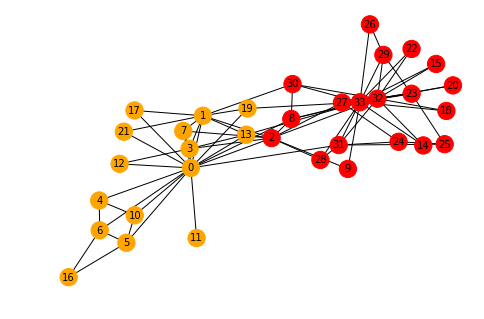

In [74]:
nx.draw(G, pos = my_pos, with_labels=True, node_color=color_map, node_size=300, edge_color='black', linewidths=1, font_size=10)
plt.savefig("my_result.png")
plt.show() 

In [36]:
cut_list = []

In [39]:
cut_dict = {}